In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import scanpy as sc

adata = sc.read_h5ad("Visium_Human_Breast_Cancer_filtered_feature_bc_matrix.h5ad")

adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

train_df = pd.read_csv("train_edges.csv")
valid_df = pd.read_csv("val_edges.csv")
test_df = pd.read_csv("test_edges.csv").drop('label', axis=1)

lr_pairs = pd.read_csv('celltalk_human_lr_pair.txt', sep='\t')

print("Train shape:", train_df.shape)
print("Valid shape:", valid_df.shape)
print("Test shape:", test_df.shape)
print("LR Pairs shape:", lr_pairs.shape)

Train shape: (12000, 3)
Valid shape: (4000, 3)
Test shape: (4000, 2)
LR Pairs shape: (3398, 10)


In [ ]:
from tqdm import tqdm
import numpy as np
import pandas as pd

expr_matrix = adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X
gene_to_idx = {gene: idx for idx, gene in enumerate(adata.var_names)}

def extract_features(cell_data):
    feature_data = []
    
    for _, row in tqdm(cell_data.iterrows(), total=len(cell_data), desc="Extracting features"):
        source_cell = row['source']
        target_cell = row['target']
        
        source_expr = expr_matrix[source_cell]
        target_expr = expr_matrix[target_cell]
        
        features = {}
        
        # 配体-受体特征
        for _, lr_row in lr_pairs.iterrows():
            ligand_gene = lr_row['ligand_gene_symbol']
            receptor_gene = lr_row['receptor_gene_symbol']
            
            if ligand_gene in gene_to_idx and receptor_gene in gene_to_idx:
                ligand_idx = gene_to_idx[ligand_gene]
                receptor_idx = gene_to_idx[receptor_gene]
                
                ligand_expr = source_expr[ligand_idx]
                receptor_expr = target_expr[receptor_idx]
                
                lr_prefix = f"{ligand_gene}_{receptor_gene}"
                
                features.update({
                    f"{lr_prefix}_ligand": ligand_expr,
                    f"{lr_prefix}_receptor": receptor_expr,
                    f"{lr_prefix}_product": ligand_expr * receptor_expr,
                    f"{lr_prefix}_mean": (ligand_expr + receptor_expr) / 2,
                    f"{lr_prefix}_ratio": ligand_expr / (receptor_expr + 1e-6),
                    f"{lr_prefix}_diff": ligand_expr - receptor_expr,
                })
        
        feature_data.append(features)
    
    feature_data = pd.DataFrame(feature_data)
    
    return feature_data

In [3]:
X_train = extract_features(train_df).values
X_valid = extract_features(valid_df).values
X_test = extract_features(test_df).values

Extracting features: 100%|██████████| 4000/4000 [05:17<00:00, 12.59it/s]


In [4]:
y_train = train_df["label"]
y_valid = valid_df["label"]
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}, y_valid shape: {y_valid.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (12000, 20370), y_train shape: (12000,)
X_valid shape: (4000, 20370), y_valid shape: (4000,)
X_test shape: (4000, 20370)


In [5]:
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


print("Building Voting-Classifier...")

base_models = [
    ('rf', RandomForestClassifier(n_estimators=500, random_state=50)),
    ('xgb', XGBClassifier(n_estimators=1000, learning_rate=0.05, random_state=50)),
    ('lgb', LGBMClassifier(n_estimators=1000, learning_rate=0.05, random_state=50, force_col_wise=True))
]

voting_clf = VotingClassifier(estimators=base_models, voting='soft', weights=[1, 1.1, 1.1])
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)

accuracy = accuracy_score(y_valid, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_valid, y_pred, average='weighted')
weighted_score = (accuracy * 0.3 + precision * 0.2 + recall * 0.2 + f1 * 0.3)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Weighted Score: {weighted_score:.4f}")

Building Voting-Classifier...
[LightGBM] [Info] Number of positive: 6000, number of negative: 6000
[LightGBM] [Info] Total Bins 281109
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 16499
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Accuracy: 0.9550
Precision: 0.9551
Recall: 0.9550
F1 Score: 0.9550
Weighted Score: 0.9550


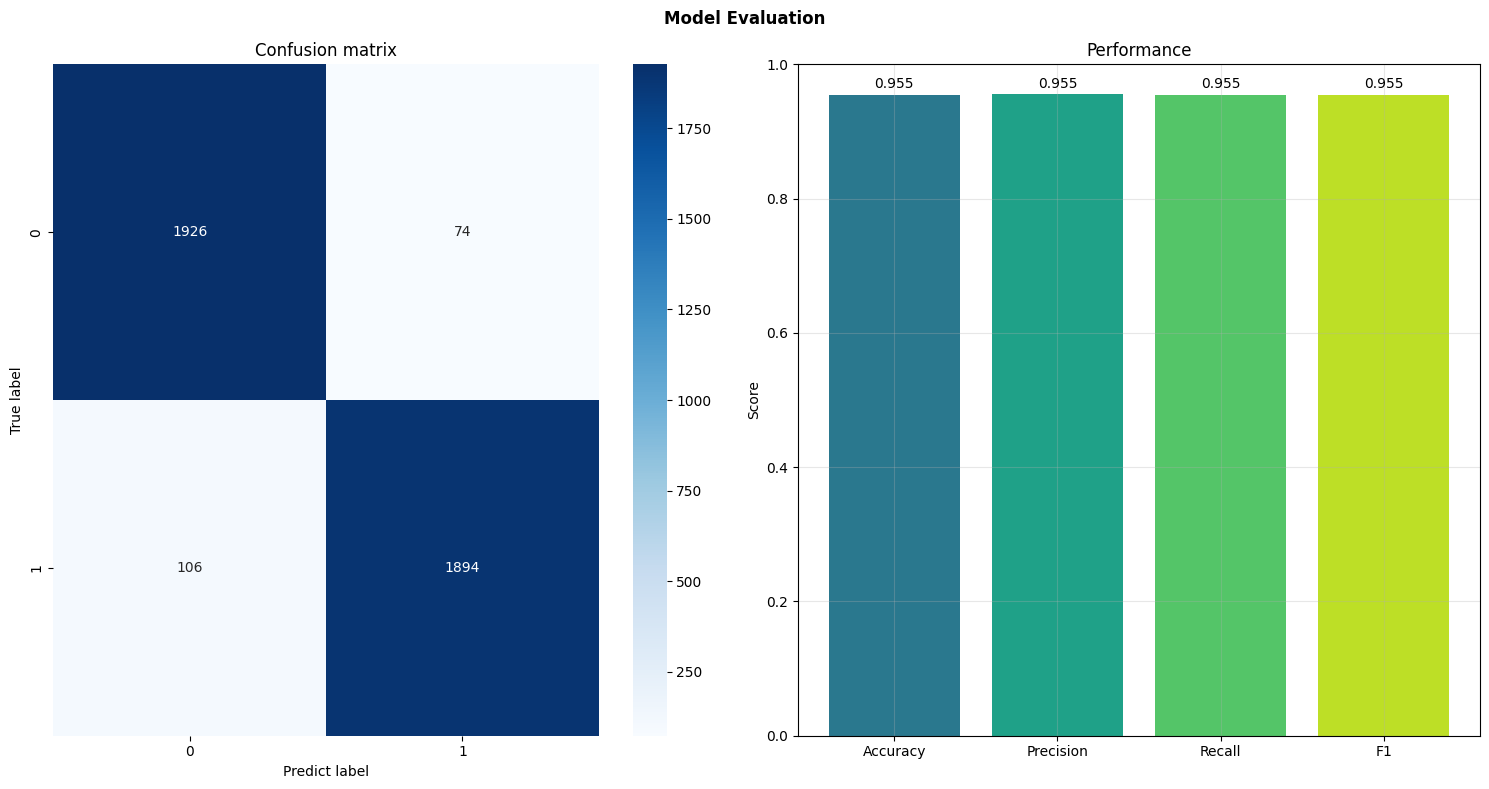

In [6]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(15, 8))
fig.suptitle(f'Model Evaluation', fontweight='bold')

# Confusion matrix
ax1 = plt.subplot(1, 2, 1)
cm = confusion_matrix(y_valid, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_xlabel('Predict label')
ax1.set_ylabel('True label')
ax1.set_title('Confusion matrix')

# Performance
ax2 = plt.subplot(1, 2, 2)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
values = [accuracy, precision, recall, f1]
colors = plt.cm.viridis(np.linspace(0.4, 0.9, len(metrics)))

bars = ax2.bar(metrics, values, color=colors)
ax2.set_ylabel('Score')
ax2.set_ylim([0, 1])
ax2.set_title('Performance')
ax2.grid(True, alpha=0.3)

for i, v in enumerate(values):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()

In [7]:
predictions = voting_clf.predict(X_test)
output = pd.DataFrame({
    "source": test_df.source, 
    "target": test_df.target, 
    "label": predictions
})
output.to_csv("submission.csv", index=False)
print("Submission file complete!")

Submission file complete!
